In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
os.listdir('../data')

['test_case_2_var_1.csv',
 'test_case_2_var_0_01.csv',
 'test_case_2_var_0_1.csv',
 'test_case_2_var_0_01_processed.npz',
 'test_case_2_no_EKF_var_0_1.csv',
 'test_case_2_no_EKF_var_1.csv',
 'test_case_2_var_1_processed.npz',
 'test_case_1_processed.npz',
 'gridded_data.csv',
 'test_case_1.csv',
 'test_case_2_no_EKF_var_0_1_processed.npz',
 'test_case_2_no_EKF_var_1_processed.npz',
 'test_case_2_var_0_001.csv']

In [60]:
!rm ../data/gridded_data_processed.npz

# Reading Data

In [64]:
filename = 'gridded_data.csv'
state_labels = ['$x$', '$y$', '$\\theta_z$', '$\\dot{x}$', '$\\dot{\\theta}_z$', '$\\theta_y$', '$\\dot{\\theta}_y$']

try:

    data_npz = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
    states = data_npz['states']
    images = data_npz['images']
    
except FileNotFoundError: 
    
    # reading datafile
    data = pd.read_csv('../data/' + filename)

    # removing irrelevant entries
    data = data[data['status']==2]
    data = data.reset_index(drop=True)


    # converting strings to arrays
    data['image'] = data['image'].str.replace('[','').str.replace(']','')
    data['image'] = data['image'].apply(np.fromstring, sep=', ')

    data['stateVec'] = data['stateVec'].str.replace('[','').str.replace(']','')
    data['stateVec'] = data['stateVec'].apply(np.fromstring, sep=', ')

    # reshaping image data
    data['image'] = data['image'].apply(np.reshape, newshape=(250,525,3 ))
    data['image'] = data['image'].apply(lambda x: x.astype(int))
    
    states = np.vstack(data['stateVec'])
    images = np.stack(data['image'])
    np.savez('../data/' + filename.split('.')[0] + '_processed.npz', states=states, images=images)

In [63]:
data

,rosbagTimestamp,time_stamp,secs,nsecs,status,stateVec,image
0,1594189064510322511,NaN,1594189064,509143686,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1594189064574807608,NaN,1594189064,573500926,2,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1594189064638201027,NaN,1594189064,636996496,2,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1594189064702895230,NaN,1594189064,701652799,2,"[0.9, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1594189064770325207,NaN,1594189064,769119474,2,"[0.8, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
746,1594189112254428869,NaN,1594189112,253291162,2,"[-0.9999999999999998, 0.0, 0.0, 0.0, 0.0, -0.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
747,1594189112318528164,NaN,1594189112,317488543,2,"[-0.9999999999999998, 0.0, 0.0, 0.0, 0.0, -0.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
748,1594189112382624352,NaN,1594189112,381528924,2,"[-0.9999999999999998, 0.0, 0.0, 0.0, 0.0, -0.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
749,1594189112446416527,NaN,1594189112,445319756,2,"[-0.9999999999999998, 0.0, 0.0, 0.0, 0.0, -0.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Plotting Data

In [4]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.slices = len(X)
        self.ind = 0

        self.im = ax.imshow(self.X[self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind - 1) % self.slices
        else:
            self.ind = (self.ind + 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

<IPython.core.display.Javascript object>


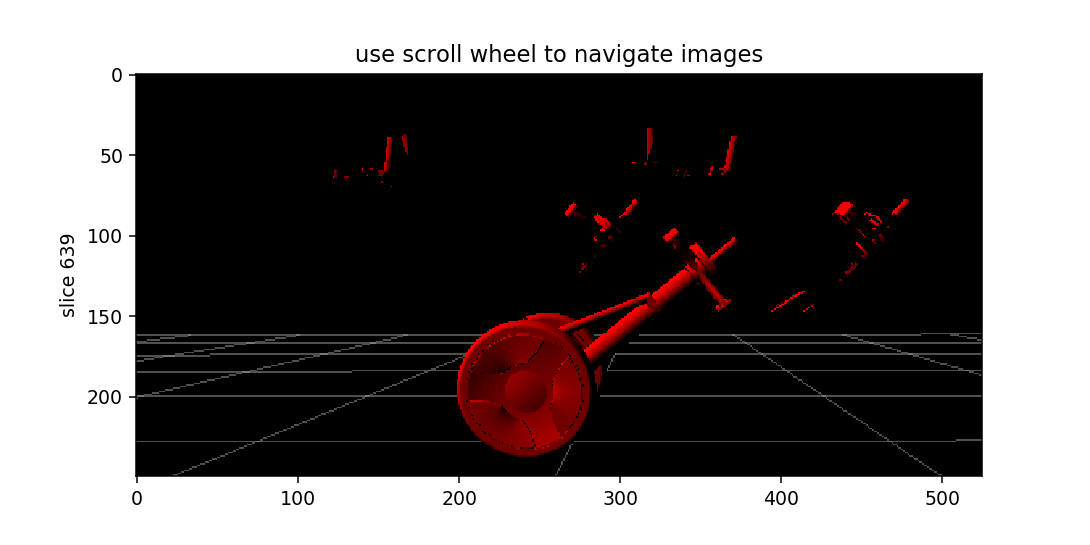

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[8,4])
tracker = IndexTracker(ax, images)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

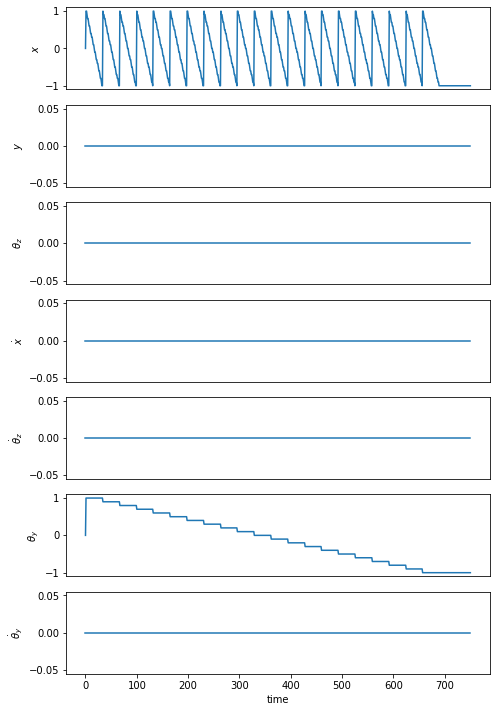

In [6]:
fig, axs = plt.subplots(len(state_labels), 1, figsize=[7,10])
for i, label in enumerate(state_labels):
    axs[i].set_ylabel(label)
    axs[i].plot(states[:,i])
    if i < len(state_labels) - 1:
        axs[i].get_xaxis().set_visible(False)
    else:
        axs[i].set_xlabel('time')
plt.tight_layout()

# Plotting Image Filters and Features

In [68]:
import skimage.feature
from skimage.color import rgb2gray
import sklearn

In [69]:
example_images = [images[1], images[12]]

<IPython.core.display.Javascript object>


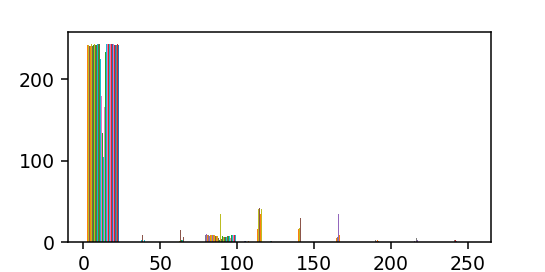

In [70]:
plt.figure(figsize=[4,2])
plt.hist(example_images[0][:,:,0]);

<IPython.core.display.Javascript object>


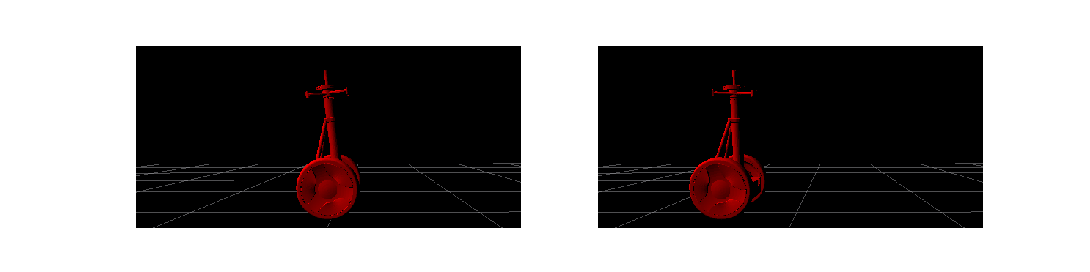

<IPython.core.display.Javascript object>


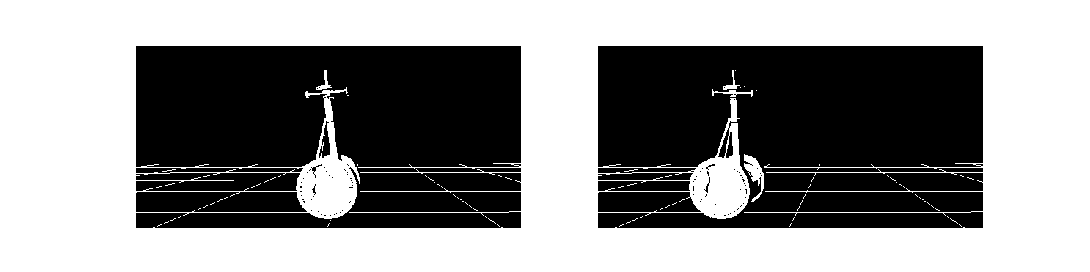

<IPython.core.display.Javascript object>


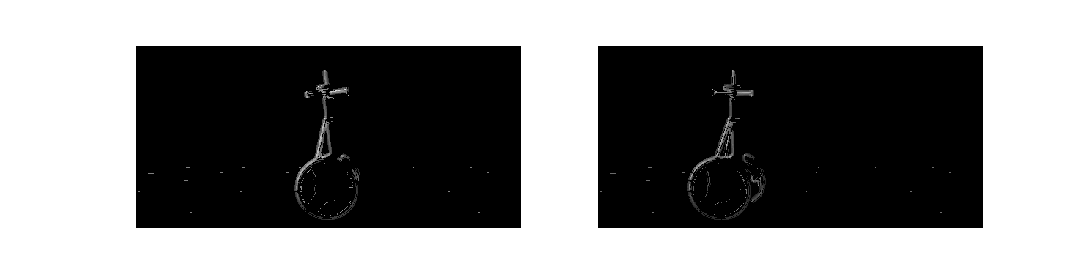

<IPython.core.display.Javascript object>


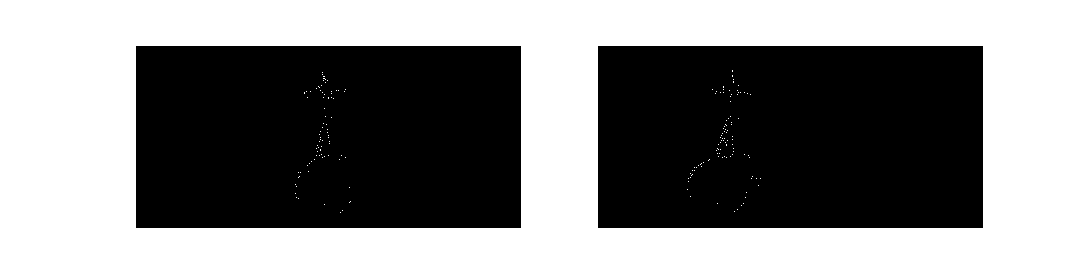

In [71]:
def plot_imgs(fn, cmap='gray'):
    plt.figure(figsize=[8,2])
    for i,img in enumerate(example_images):
        plt.subplot(1,len(example_images),i+1)
        plt.imshow(fn(img), cmap=cmap)
        plt.axis('off')
    
plot_imgs(lambda img: img, cmap=None)
# plot_imgs(lambda img: img[:,:,0])
# plot_imgs(lambda img: skimage.filters.sobel(img[:,:,0]))
plot_imgs(lambda img: skimage.filters.apply_hysteresis_threshold(img[:,:,0], low=50, high=50))
# plot_imgs(lambda img: skimage.feature.canny(img[:,:,0], low_threshold=50, high_threshold=50))
# plot_imgs(lambda img: skimage.feature.corner_fast(skimage.feature.canny(img[:,:,0], low_threshold=50, high_threshold=50), n=12, threshold=0.15))
plot_imgs(lambda img: skimage.feature.corner_fast(img[:,:,0], n=4, threshold=1e-17))
plot_imgs(lambda img: skimage.feature.corner_peaks(skimage.feature.corner_fast(img[:,:,0], 
                                                                               n=4, threshold=1.5e-17),
                                                  indices=False))


In [72]:
img = example_images[0]
detector_extractor = skimage.feature.ORB(downscale=1.01, fast_n=4, fast_threshold=2e-17, harris_k=0.2)
detector_extractor.detect_and_extract(img[:,:,0])
detector_extractor.descriptors
detector_extractor.keypoints.shape

(241, 2)

# Dataset variation differences

In [72]:
file_names = ['test_case_2_var_1.csv',
             'test_case_2_no_EKF_var_0_1.csv',
             'test_case_1.csv',
             'gridded_data.csv']

<IPython.core.display.Javascript object>


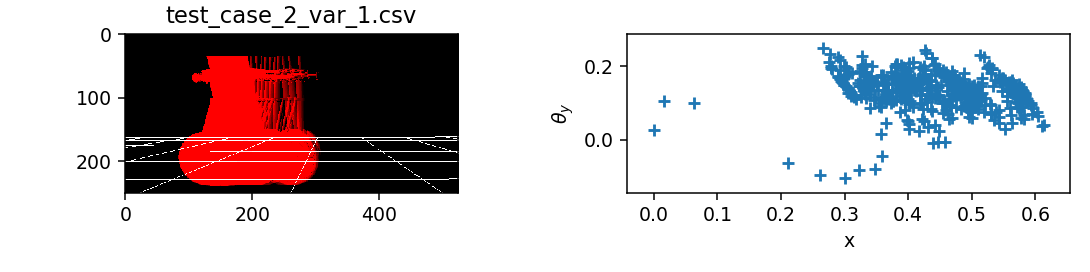

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


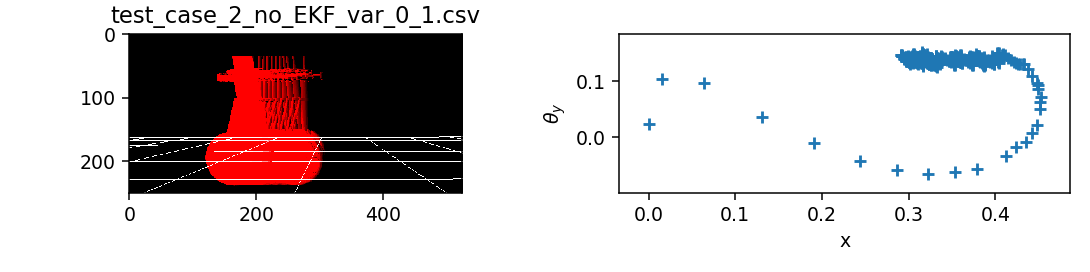

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


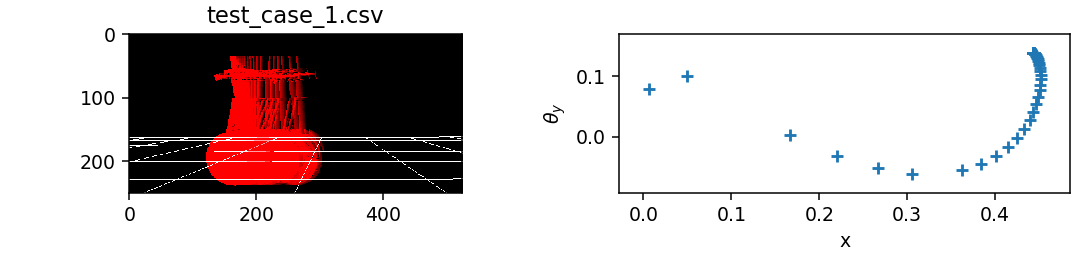

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


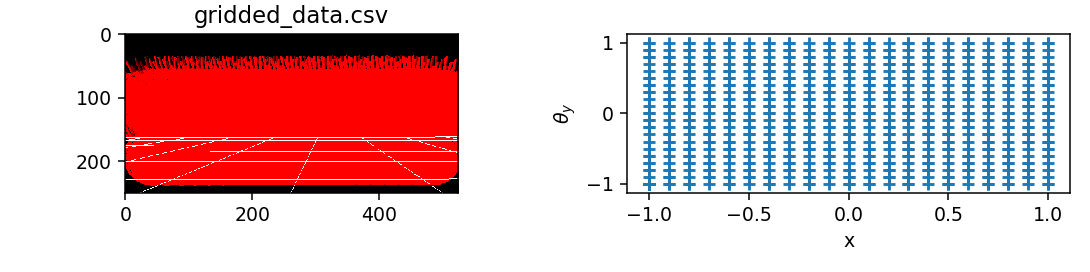

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [73]:
# reading datafile
# filename = 'test_case_1.csv'
for filename in file_names:
    data = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
    states = data['states']
    images = data['images']
    plt.figure(figsize=[8,2])
    plt.subplot(1,2,1)
    plt.title(filename)
    plt.imshow(np.sum(images, axis=0))
    plt.subplot(1,2,2)
    plt.scatter(states[:,0], states[:,5], marker='+')
    plt.xlabel('x'); plt.ylabel('$\\theta_y$')
    plt.tight_layout()

# Learning

In [9]:
filename = 'gridded_data.csv'

# load data
data = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
states = data['states']
images = data['images']



In [10]:
# test/train split
method = 'random'

if method == 'random':

    selected_inds = np.random.choice(len(states), size=int(len(states)*0.2), replace=False)
    test_inds = np.zeros(len(states), dtype=bool)
    test_inds[selected_inds] = True
    train_inds = np.logical_not(test_inds)

    ys = {'test': states[test_inds][:,[0,5]], 'train': states[train_inds][:,[0,5]]}
    zs = {'test': images[test_inds], 'train': images[train_inds]}
    
elif method == 'new_dataset':

    filename2 = 'test_case_2_no_EKF_var_0_1.csv' #'test_case_2_no_EKF_var_1.csv'

    data2 = np.load('../data/' + filename2.split('.')[0] + '_processed.npz')
    states2 = data2['states']
    images2 = data2['images']

    ys = {'test': states2[:,[0,5]], 'train': states[:,[0,5]]}
    zs = {'test': images2, 'train': images}
    

In [11]:
import perception as per

In [19]:
Pred = per.KernelRidgePredictor(ys=ys['train'], zs=zs['train'], lam=0) #, features='canny')

In [39]:
from sklearn.kernel_ridge import KernelRidge

X = zs['train'].reshape(zs['train'].shape[0], -1)


clf = KernelRidge(alpha=0, kernel='rbf') #, gamma=1e-9)
clf.fit(X, ys['train'])

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


KernelRidge(alpha=0, coef0=1, degree=3, gamma=None, kernel='rbf',
            kernel_params=None)

In [40]:
ys_pred = clf.predict(zs['test'].reshape(zs['test'].shape[0], -1))
ys_pred_train = clf.predict(zs['train'].reshape(zs['train'].shape[0], -1))

In [58]:
1/393750

2.53968253968254e-06

In [21]:
ys_pred = Pred.pred(zs['test'])
ys_pred_train = Pred.pred(zs['train'])

[autoreload of perception failed: Traceback (most recent call last):
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/home/sarah/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visi

In [17]:
ys_pred_train

array([[ 0.17792559, -0.00834569],
       [ 0.82494402,  1.00732556],
       [ 0.82494402,  1.00732556],
       ...,
       [ 1.71176958, -1.12975273],
       [ 1.71176958, -1.12975273],
       [ 1.71103621, -1.12978515]])

<IPython.core.display.Javascript object>


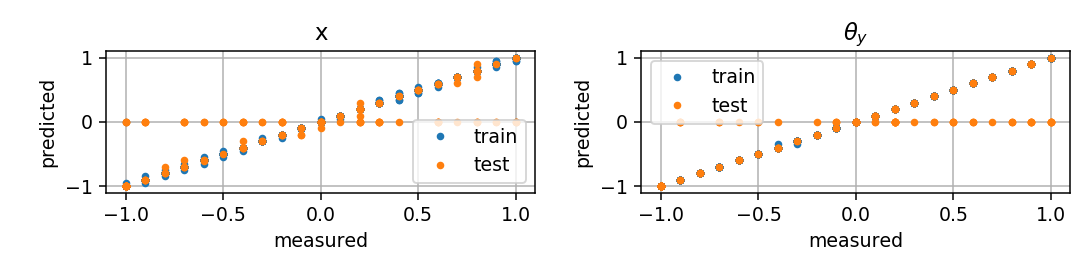

In [41]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.title('x')
plt.plot(ys['train'][:,0],ys_pred_train[:,0], '.', label='train')
plt.plot(ys['test'][:,0],ys_pred[:,0], '.', label='test')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.title('$\\theta_y$')
plt.plot(ys['train'][:,1],ys_pred_train[:,1], '.', label='train')
plt.plot(ys['test'][:,1],ys_pred[:,1], '.', label='test')
plt.legend()
plt.grid()
plt.tight_layout()

In [48]:
.shape

(601,)

<IPython.core.display.Javascript object>


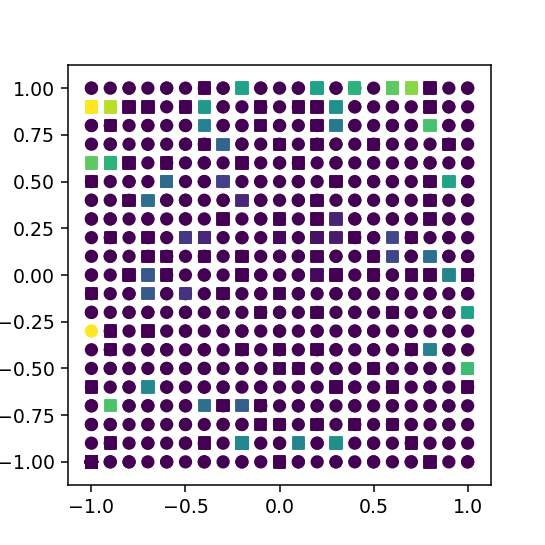

<IPython.core.display.Javascript object>


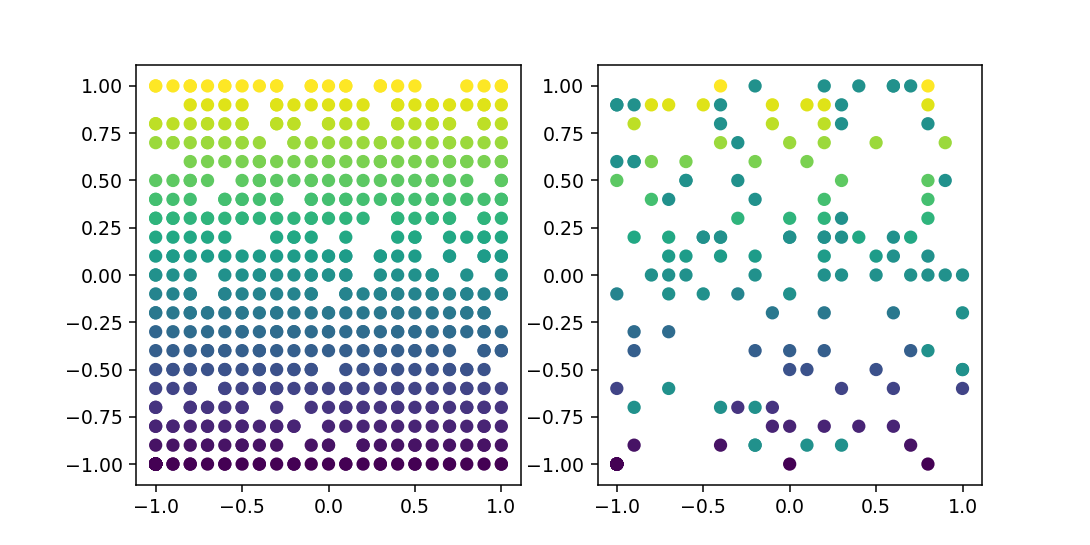

In [71]:
plt.figure(figsize=[4,4])
plt.scatter(ys['train'][:,0], ys['train'][:,1], c=np.sum((ys['train']-ys_pred_train)**2, axis=1))
plt.scatter(ys['test'][:,0], ys['test'][:,1], c=np.sum((ys['test']-ys_pred)**2, axis=1), marker='s')


plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.scatter(ys['train'][:,0], ys['train'][:,1], c=ys_pred_train[:,1])
plt.subplot(1,2,2)
plt.scatter(ys['test'][:,0], ys['test'][:,1], c=ys_pred[:,1])



In [35]:
ahat = Pred.ahat.reshape(2, 250, -1)
plt.figure(figsize=[9,2])
plt.subplot(1,2,1)
plt.title('x')
plt.imshow(ahat[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.title('$\\theta_y$')
plt.imshow(ahat[1])
plt.colorbar()
plt.tight_layout()

AttributeError: 'KernelRidgePredictor' object has no attribute 'ahat'

In [66]:
res

{'mean': {}, 'mae': {}, 'median': {}, 'max': {}}

In [121]:
import numpy as np
import sklearn.metrics
import train_models

train_data_fn = 'gridded_data.csv'
test_data = 'uniform'

Xs, ys = train_models.get_test_train_data(train_data_fn, test_data)

data = np.load('../data/coeff_train{}_test{}.npz'.format(train_data_fn, test_data))
coeff = data['coeff'] 
gamma = data['gamma']
alpha = data['alpha']

reg = KernelRidge()
reg.set_params(alpha=alpha, gamma=gamma)
reg.fit(Xs['train'], ys['train'])


/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [122]:
y_pred_old = reg.predict(Xs['train'])

In [123]:
y_pred_old

array([[-1.05932355e-04, -1.34114941e-13],
       [ 9.99086663e-01,  1.00000000e+00],
       [ 9.99086663e-01,  1.00000000e+00],
       ...,
       [-9.99819458e-01, -1.00000000e+00],
       [-9.99819458e-01, -1.00000000e+00],
       [-9.99813497e-01, -1.00000000e+00]])

In [133]:
def new_predict(Xs_new):
#     K = reg._get_kernel(Xs_new, Xs['train'])
    K = sklearn.metrics.pairwise.rbf_kernel(Xs_new, Xs['train'], gamma=gamma)
    return np.dot(K, reg.dual_coef_)

In [134]:
y_pred = new_predict(Xs['train'])

In [136]:
y_pred

array([[-1.05932355e-04, -1.34114941e-13],
       [ 9.99086663e-01,  1.00000000e+00],
       [ 9.99086663e-01,  1.00000000e+00],
       ...,
       [-9.99819458e-01, -1.00000000e+00],
       [-9.99819458e-01, -1.00000000e+00],
       [-9.99813497e-01, -1.00000000e+00]])

In [68]:
min(scoring)

'mae'

In [137]:

import numpy as np
import sklearn.metrics
import train_models

train_data_fn = 'gridded_data.csv'
test_data = 'uniform'

# Xs, ys = train_models.get_test_train_data(train_data_fn, test_data)

data = np.load('../data/coeff_train{}_test{}.npz'.format(train_data_fn, test_data))
coeff = data['coeff'] 
gamma = data['gamma']
alpha = data['alpha']

# reg = KernelRidge()
# reg.set_params(alpha=alpha, gamma=gamma)
# reg.fit(Xs['train'], ys['train'])


Xs_train = data['Xs_train']

In [138]:

def predict(Xs):
    kernel = sklearn.metrics.pairwise.rbf_kernel(Xs, Xs_train, gamma=gamma)
    return np.dot(kernel, coeff)



In [139]:
# confirming that model was loaded correctly
y_pred_old = data['y_pred']
y_pred = predict(Xs_train)

In [143]:
np.testing.assert_allclose(y_pred, y_pred_old)

array([[ 1.45716772e-16,  1.45716772e-16],
       [ 1.00000005e+00,  1.00000000e+00],
       [ 1.00000005e+00,  1.00000000e+00],
       ...,
       [-1.00030518e+00, -1.00000000e+00],
       [-1.00030518e+00, -1.00000000e+00],
       [-1.00006104e+00, -1.00000000e+00]])

<IPython.core.display.Javascript object>


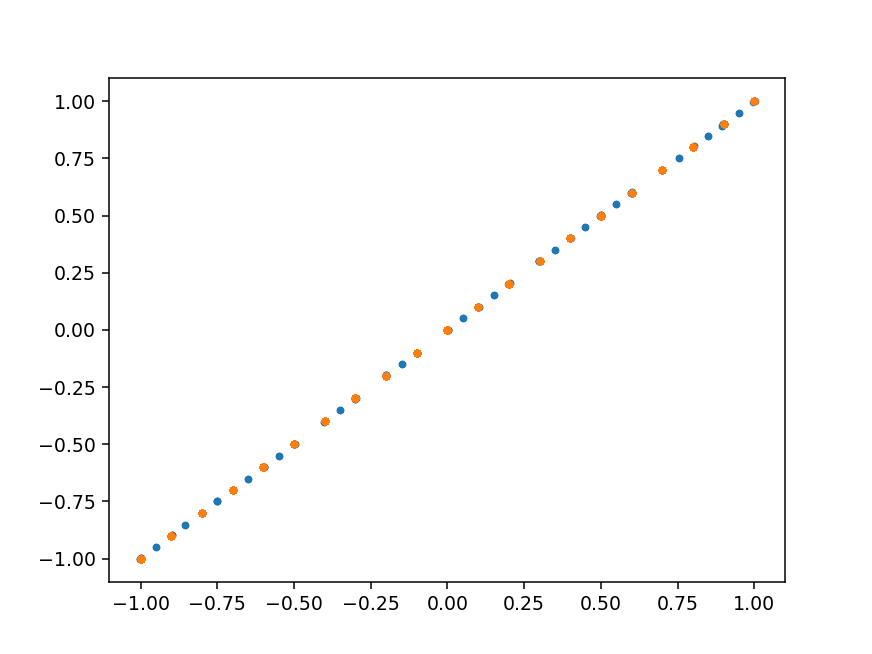

In [142]:
plt.figure()
plt.plot(y_pred_old[:,0], y_pred[:,0], '.')
plt.plot(y_pred_old[:,1], y_pred[:,1], '.')

In [97]:
coeff

array([[ 3.49941598e-03, -1.80362640e-09],
       [ 2.03827081e+01,  4.30263337e-08],
       [-2.03827081e+01,  4.31808035e-08],
       ...,
       [-4.11284110e-02, -2.50605915e-09],
       [ 2.74070539e-02, -2.50631885e-09],
       [ 5.73332210e-01, -2.50838749e-09]])